In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

## Gradient Tracker

In [2]:
# 1. Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [3]:
# 2. Build deep MLP with configurable activation
def build_deep_mlp(activation):
    model = models.Sequential()
    model.add(layers.Input(shape=(784,)))
    for _ in range(20):  # very deep network
        model.add(layers.Dense(64, activation=activation))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
# 3. Track gradient norms
class GradientTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        with tf.GradientTape() as tape:
            inputs = tf.convert_to_tensor(x_train_small[:256])
            targets = tf.convert_to_tensor(y_train_small[:256])
            preds = self.model(inputs, training=True)
            loss = self.model.compiled_loss(targets, preds)
        grads = tape.gradient(loss, self.model.trainable_variables)
        norms = [tf.norm(g) for g in grads if g is not None]
        mean_norm = tf.reduce_mean(norms).numpy()
        self.gradient_norms.append(mean_norm)

In [6]:
# 4. Train models with different activations
activations = ['sigmoid', 'tanh', 'relu']
histories = {}
gradients = {}
test_results = {}

# Create smaller subsets of the training data for faster training
x_train_small = x_train[:10000]
y_train_small = y_train[:10000]

for act in activations:
    print(f"\nTraining with activation: {act}")
    model = build_deep_mlp(act)
    tracker = GradientTracker()
    history = model.fit(
        x_train_small, y_train_small,
        validation_split=0.2,
        epochs=10,
        batch_size=128,
        verbose=0,
        callbacks=[tracker]
    )
    histories[act] = history.history
    gradients[act] = tracker.gradient_norms
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    test_results[act] = acc
    print(f"Test Accuracy ({act}): {acc:.4f}")


Training with activation: sigmoid


2025-10-21 14:46:28.126690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/deepak/miniconda3/envs/mlenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:673: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


Test Accuracy (sigmoid): 0.1135

Training with activation: tanh
Test Accuracy (tanh): 0.8681

Training with activation: relu
Test Accuracy (relu): 0.4608


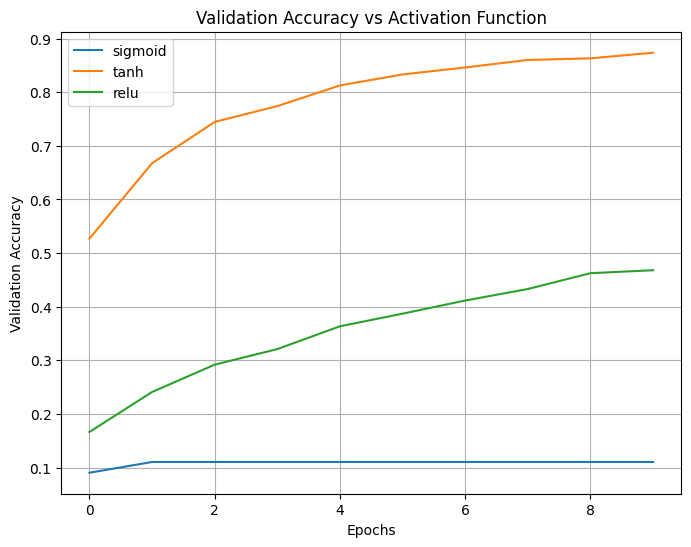

In [7]:
# 5. Plot validation accuracy
plt.figure(figsize=(8, 6))
for act in activations:
    plt.plot(histories[act]['val_accuracy'], label=f"{act}")
plt.title("Validation Accuracy vs Activation Function")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

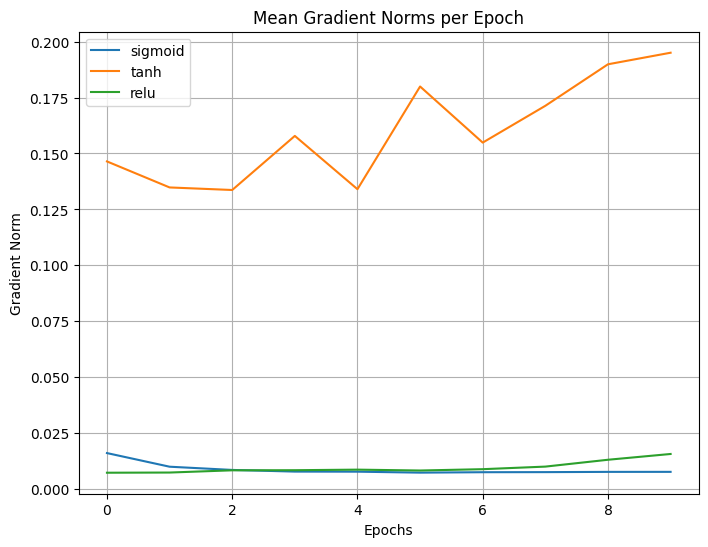

In [8]:
# 6. Plot gradient norms
plt.figure(figsize=(8, 6))
for act in activations:
    plt.plot(gradients[act], label=f"{act}")
plt.title("Mean Gradient Norms per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 7. Print final test accuracies
print("\nFinal Test Accuracies:")
for act, acc in test_results.items():
    print(f"{act}: {acc:.4f}")


Final Test Accuracies:
sigmoid: 0.1135
tanh: 0.8681
relu: 0.4608
